In [31]:
!pip install ipywidgets


  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)


In [23]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("data/online_sales.csv")

# Display basic info
print("✔️ Data loaded successfully!")
df.head()


✔️ Data loaded successfully!


,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:29,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21 15:37:04,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items


In [24]:
# ----- Step 4: Clean and Prepare the Data

df_clean = df.copy()

# 1. Standardize column names (lowercase + underscores)
df_clean.columns = [col.lower().strip().replace(" ", "_") for col in df_clean.columns]

# To confirm the columns after cleaning
print("Columns after cleaning:", df_clean.columns.tolist())

# 2. Convert date column -> 'date'
if "date" in df_clean.columns:
    df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")
else:
    raise KeyError("Expected a 'date' column but did not find one.")

# 3. Convert numeric columns: total_items and total_cost
for col in ["total_items", "total_cost"]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# 4. Create a quantity column for convenience (from total_items)
if "total_items" in df_clean.columns:
    df_clean["quantity"] = df_clean["total_items"]

# 5. Create revenue column (from total_cost)
if "total_cost" in df_clean.columns:
    df_clean["revenue"] = df_clean["total_cost"]
else:
    raise KeyError("Expected a 'total_cost' column to create revenue but did not find one.")

# 6. Remove rows with missing essential values
df_clean = df_clean.dropna(subset=["date", "quantity", "revenue"])

# 7. Create year-month column for grouping
df_clean["year_month"] = df_clean["date"].dt.to_period("M").astype(str)

# Show cleaned preview
df_clean.head()



Columns after cleaning: ['transaction_id', 'date', 'customer_name', 'product', 'total_items', 'total_cost', 'payment_method', 'city', 'store_type', 'discount_applied', 'customer_category', 'season', 'promotion']


,transaction_id,date,customer_name,product,total_items,total_cost,payment_method,city,store_type,discount_applied,customer_category,season,promotion,quantity,revenue,year_month
0,1000000000,2022-01-21 06:27:29,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN,3,71.65,2022-01
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One),2,25.93,2023-03
2,1000000002,2024-03-21 15:37:04,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN,6,41.49,2024-03
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN,1,39.34,2020-10
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items,10,16.42,2020-12


In [25]:
df_clean.columns


Index(['transaction_id', 'date', 'customer_name', 'product', 'total_items',
       'total_cost', 'payment_method', 'city', 'store_type',
       'discount_applied', 'customer_category', 'season', 'promotion',
       'quantity', 'revenue', 'year_month'],
      dtype='object')

In [26]:
# ----- Step 5: Calculate KPIs -----

# 1. Total revenue
total_revenue = df_clean["revenue"].sum()

# 2. Total number of transactions
total_transactions = df_clean.shape[0]

# 3. Average order value (revenue per transaction)
avg_order_value = df_clean["revenue"].mean()

# 4. Total items sold
total_items_sold = df_clean["quantity"].sum()

# 5. Top 5 products by revenue
revenue_by_product = (
    df_clean.groupby("product")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# 6. Top 5 cities by revenue (if city exists)
if "city" in df_clean.columns:
    revenue_by_city = (
        df_clean.groupby("city")["revenue"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )
else:
    revenue_by_city = None

# 7. Monthly revenue trend
revenue_by_month = (
    df_clean.groupby("year_month")["revenue"]
    .sum()
    .sort_index()
)

# ---- Print the KPIs ----
print("📊 KEY PERFORMANCE INDICATORS (KPIs)")
print("------------------------------------")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Transactions: {total_transactions}")
print(f"Average Order Value: ${avg_order_value:,.2f}")
print(f"Total Items Sold: {total_items_sold:,.0f}\n")

print("Top 5 Products by Revenue:")
print(revenue_by_product, "\n")

if revenue_by_city is not None:
    print("Top 5 Cities by Revenue:")
    print(revenue_by_city, "\n")

print("Monthly Revenue Trend:")
print(revenue_by_month)


📊 KEY PERFORMANCE INDICATORS (KPIs)
------------------------------------
Total Revenue: $52,455,220.40
Total Transactions: 1000000
Average Order Value: $52.46
Total Items Sold: 5,495,941

Top 5 Products by Revenue:
product
['Toothpaste']    253689.01
['Honey']         135409.85
['Deodorant']     133082.77
['Pasta']         131765.69
['Eggs']          131565.71
Name: revenue, dtype: float64 

Top 5 Cities by Revenue:
city
Dallas      5277111.53
Boston      5263307.96
Chicago     5263187.45
New York    5252469.92
Houston     5247054.78
Name: revenue, dtype: float64 

Monthly Revenue Trend:
year_month
2020-01    1023565.45
2020-02     953488.19
2020-03    1015781.37
2020-04     988549.87
2020-05    1001696.33
2020-06     988630.18
2020-07    1012661.97
2020-08    1022764.43
2020-09     989218.28
2020-10    1008214.78
2020-11     998095.24
2020-12    1012884.46
2021-01    1019424.75
2021-02     914130.51
2021-03    1021530.14
2021-04     977534.57
2021-05    1011122.43
2021-06     991433.7

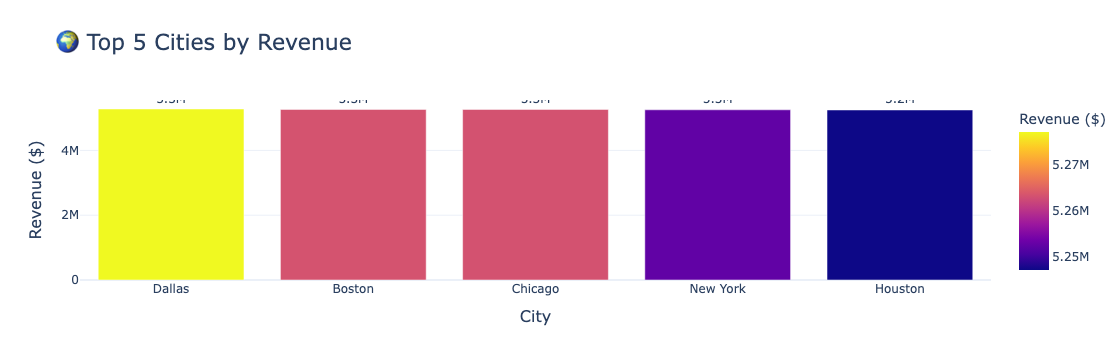

In [27]:
import plotly.express as px

# ----- Improved Visualization 1: Monthly Revenue Trend -----
fig1 = px.line(
    revenue_by_month.reset_index(),
    x="year_month",
    y="revenue",
    markers=True,
    title="📈 Monthly Revenue Trend",
    labels={"year_month": "Month", "revenue": "Revenue ($)"}
)

fig1.update_layout(
    title_font_size=22,
    xaxis_title_font_size=20,
    yaxis_title_font_size=20,
    template="plotly_white"
)
fig1.show()


# ----- Improved Visualization 2: Top 5 Products By Revenue -----
fig2 = px.bar(
    revenue_by_product.reset_index(),
    x="product",
    y="revenue",
    title="🏆 Top 5 Products by Revenue",
    labels={"product": "Product", "revenue": "Revenue ($)"},
    color="revenue",
    text="revenue"
)

fig2.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig2.update_layout(
    title_font_size=22,
    xaxis_title_font_size=16,
    yaxis_title_font_size=20,
    template="plotly_white",
    uniformtext_minsize=12,
    uniformtext_mode='hide'
)
fig2.show()

# ----- Improved Visualization 3: Top 5 Cities by Revenue -----
if revenue_by_city is not None:
    fig3 = px.bar(
        revenue_by_city.reset_index(),
        x="city",
        y="revenue",
        title="🌍 Top 5 Cities by Revenue",
        labels={"city": "City", "revenue": "Revenue ($)"},
        color="revenue",
        text="revenue"
    )

    fig3.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig3.update_layout(
        title_font_size=22,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        template="plotly_white",
        uniformtext_minsize=12,
        uniformtext_mode='hide'
    )

    fig3.show()
else:
    print("No city column found — skipping city chart.")



In [28]:
# ----- Step 7.1: Build a summary string from KPIs -----

summary_lines = []

summary_lines.append("=== High-Level Sales Summary ===")
summary_lines.append(f"Total revenue: ${total_revenue:,.2f}")
summary_lines.append(f"Total transactions: {total_transactions}")
summary_lines.append(f"Average order value: ${avg_order_value:,.2f}")
summary_lines.append(f"Total items sold: {total_items_sold:,.0f}")

summary_lines.append("\n=== Top 5 Products by Revenue ===")
for product, value in revenue_by_product.items():
    summary_lines.append(f"- {product}: ${value:,.2f}")

if revenue_by_city is not None:
    summary_lines.append("\n=== Top 5 Cities by Revenue ===")
    for city, value in revenue_by_city.items():
        summary_lines.append(f"- {city}: ${value:,.2f}")

summary_lines.append("\n=== Monthly Revenue (chronological) ===")
for ym, value in revenue_by_month.items():
    summary_lines.append(f"- {ym}: ${value:,.2f}")

kpi_summary_text = "\n".join(summary_lines)

print(kpi_summary_text[:1500])  # print first 1500 chars just in case


=== High-Level Sales Summary ===
Total revenue: $52,455,220.40
Total transactions: 1000000
Average order value: $52.46
Total items sold: 5,495,941

=== Top 5 Products by Revenue ===
- ['Toothpaste']: $253,689.01
- ['Honey']: $135,409.85
- ['Deodorant']: $133,082.77
- ['Pasta']: $131,765.69
- ['Eggs']: $131,565.71

=== Top 5 Cities by Revenue ===
- Dallas: $5,277,111.53
- Boston: $5,263,307.96
- Chicago: $5,263,187.45
- New York: $5,252,469.92
- Houston: $5,247,054.78

=== Monthly Revenue (chronological) ===
- 2020-01: $1,023,565.45
- 2020-02: $953,488.19
- 2020-03: $1,015,781.37
- 2020-04: $988,549.87
- 2020-05: $1,001,696.33
- 2020-06: $988,630.18
- 2020-07: $1,012,661.97
- 2020-08: $1,022,764.43
- 2020-09: $989,218.28
- 2020-10: $1,008,214.78
- 2020-11: $998,095.24
- 2020-12: $1,012,884.46
- 2021-01: $1,019,424.75
- 2021-02: $914,130.51
- 2021-03: $1,021,530.14
- 2021-04: $977,534.57
- 2021-05: $1,011,122.43
- 2021-06: $991,433.74
- 2021-07: $1,021,536.65
- 2021-08: $1,010,434.45
- 2

In [ ]:
# ----- Step 7.2: Use an AI model to generate insights -----

from openai import OpenAI
import os

# Make sure your API key is set in the environment:
os.environ["OPENAI_API_KEY"] = "Your_api_key" 
client = OpenAI()

prompt = f"""
You are a senior sales analyst.

Based on the following sales KPI summary, provide:
1. 5 Key Insights about sales performance
2. 3 Potential Risks or concerns
3. 3 Opportunities for growth
4. 5 Actionable Recommendations for the business

Be concise, use bullet points, and keep the language clear for non-technical stakeholders.

Sales KPI Summary:
{kpi_summary_text}
"""

response = client.responses.create(
    model="gpt-4.1-mini",  # or another model you have access to
    input=prompt,
)

# Extract the text from the response
ai_text = response.output[0].content[0].text

print(ai_text)


### 1. Key Insights about Sales Performance
- **Consistent Quarterly Revenue:** Monthly revenue shows steady performance around $950K-$1.03M, indicating stable demand with minor fluctuations.
- **Significant Revenue Contribution from Top Cities:** Dallas, Boston, Chicago, New York, and Houston each contribute roughly $5.2M, collectively accounting for nearly half of total revenue.
- **Moderate Average Order Value:** The average order value is $52.46, reflecting moderate spending per transaction.
- **Low Revenue from Top Products:** The top 5 products together contribute less than $800K, less than 2% of total revenue, suggesting a broad product mix or sales spread across many products.
- **Seasonal Revenue Drop in May 2024:** A sharp drop to $586,965.49 in May 2024 likely indicates an unusual disruption or event affecting sales.

### 2. Potential Risks or Concerns
- **Revenue Concentration Risk:** Heavy reliance on a few key cities (top 5 generate ~50% revenue) poses risk if market cond

In [ ]:
# ----- Step 7.2: Use an AI model to generate insights -----

from openai import OpenAI
import os

# Make sure your API key is set in the environment:
os.environ["OPENAI_API_KEY"] = "Your-api-key"  
client = OpenAI()

prompt = f"""
You are a senior sales analyst.

Based on the following sales KPI summary, provide:
1. 5 Key Insights about sales performance
2. 3 Potential Risks or concerns
3. 3 Opportunities for growth
4. 5 Actionable Recommendations for the business

Be concise, use bullet points, and keep the language clear for non-technical stakeholders.

Sales KPI Summary:
{kpi_summary_text}
"""

response = client.responses.create(
    model="gpt-4.1-mini",  # or another model you have access to
    input=prompt,
)

# Extract the text from the response
ai_text = response.output[0].content[0].text

print(ai_text)


**1. Key Insights about Sales Performance:**  
- Total revenue is strong at over $52 million with 1 million transactions, showing a healthy volume of sales.  
- Average order value of $52.46 indicates moderate spending per transaction, consistent over the period.  
- The top 5 products’ revenues are relatively low compared to total revenue, indicating a wide product mix with no single product dominating sales.  
- Top 5 cities each contribute approximately $5.2 million in revenue, showing balanced geographic revenue distribution.  
- Monthly revenue is generally stable between $900K and $1M, but shows a sharp drop to $586K in May 2024, suggesting a recent issue or anomaly.

**2. Potential Risks or Concerns:**  
- Significant revenue drop in May 2024 (down ~40% compared to previous months), which could signal supply chain, operational, or demand issues.  
- No single product is a major revenue generator, which might indicate weak product differentiation or low high-margin product sales.